In [ ]:
import numpy as np
from __future__ import division, print_function

### Get validation set predictions and labels

You can use the "Generate Simulated Predictions" notebook in this folder to produce the data used in this example notebook.

If using a deep learning model to make predictions, provide the predictions before the final nonlinearity

In [30]:
valid_preds_and_labels_file = "valid_preds_and_labels.txt"

valid_preds = []
valid_labels = []
for a_line in open(valid_preds_and_labels_file):
    a_line = a_line.rstrip()
    valid_pred, valid_label = a_line.split("\t")
    valid_preds.append(float(valid_pred))
    valid_labels.append(int(valid_label))
valid_preds = np.array(valid_preds)
valid_labels = np.array(valid_labels)

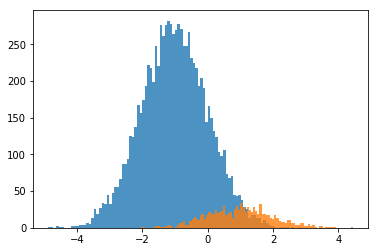

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(valid_preds[valid_labels==0], alpha=0.8, bins=100)
plt.hist(valid_preds[valid_labels==1], alpha=0.8, bins=100)
plt.show()

### Perform calibration

In [32]:
import abstention

#Isotonic Regression is more flexible than Platt scaling
#But note that it can sometimes overfit. For deep learning
#models and binary classification, we have found Platt
#Scaling to generally work better

ir_calibrator = abstention.calibration.IsotonicRegression()(
                #the argument is named "preacts" because
                #in a deep learning model, you should provide
                #the predictions before the final nonlinearity
                valid_preacts = valid_preds,
                valid_labels = valid_labels)
platt_calibrator = abstention.calibration.PlattScaling()(
                #the argument is named "preacts" because
                #in a deep learning model, you should provide
                #the predictions before the final nonlinearity
                valid_preacts = valid_preds,
                valid_labels = valid_labels)

Platt scaling coef: 1.9539529400537776 ; intercept: -2.1330916580217214


Visualize the results of the calibration

Plot the calibration functions


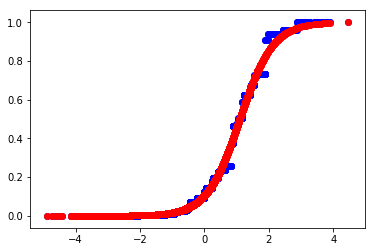

Plot the quality of the calibration - be aware of overfitting!


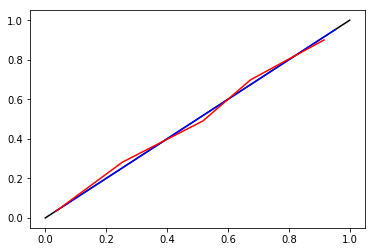

In [33]:
print("Plot the calibration functions")
ir_calibrated_valid_preds = ir_calibrator(valid_preds)
platt_calibrated_valid_preds = platt_calibrator(valid_preds)
plt.scatter(valid_preds, ir_calibrated_valid_preds, color='blue')
plt.scatter(valid_preds, platt_calibrated_valid_preds, color='red')
plt.show()

print("Plot the quality of the calibration - be aware of overfitting!")
import sklearn.calibration

plt.plot([0.0, 1.0], [0.0, 1.0], color='black')
plt.plot(*sklearn.calibration.calibration_curve(y_true=valid_labels, y_prob=ir_calibrated_valid_preds), color='blue')
plt.plot(*sklearn.calibration.calibration_curve(y_true=valid_labels, y_prob=platt_calibrated_valid_preds), color='red')
plt.show()

Platt scaling and IR produced similar results. Since there's a good chance IR overfit, we will use Platt.

### Get abstention priorities for test predictions

In [34]:
test_preds = np.array([float(x.rstrip()) for x in open("test_preds.txt")])
calibrated_test_preds = platt_calibrator(test_preds)

If valid_est_metric and data_est_metric are reasonably close, that's an indication that the calibration on the test set is good. valid_est_metric is the performance computed on the validation set; data_est_metric is the performance computed directly from the test-set probabilities.

In [41]:
abstainer_func_auprc = abstention.abstention.MarginalDeltaAuPrc()(valid_labels=valid_labels,
                                                                  valid_posterior=platt_calibrated_valid_preds)
abstention_priorities_auprc = abstainer_func_auprc(posterior_probs=calibrated_test_preds)

abstainer_func_auroc = abstention.abstention.MarginalDeltaAuRoc()(valid_labels=valid_labels,
                                                                  valid_posterior=platt_calibrated_valid_preds)
abstention_priorities_auroc = abstainer_func_auroc(posterior_probs=calibrated_test_preds)

valid est metric 0.6591974242327812
data est metric 0.6544519424645587
valid est metric 0.9202534975110312
data est metric 0.9166502240893657


Calibrated probabilities


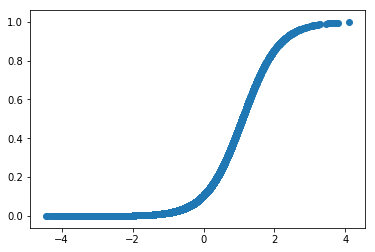

AuPRC abstention scores


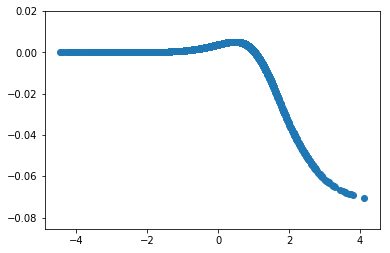

AuROC abstention scores


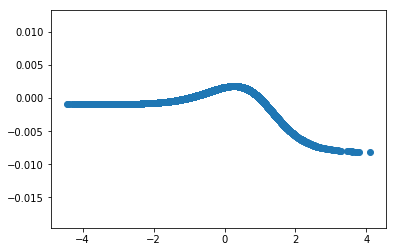

In [42]:
print("Calibrated probabilities")
plt.scatter(test_preds, calibrated_test_preds)
plt.show()
print("AuPRC abstention scores")
plt.scatter(test_preds, abstention_priorities_auprc*100)
plt.show()
print("AuROC abstention scores")
plt.scatter(test_preds, abstention_priorities_auroc*100)
plt.show()
